In [2]:
#%% Mount Google drive if you use colab for save and load files
if 'google.colab' in str(get_ipython()):
  colab = 1
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')

  # Set your path on the google drive here for save and download files
  path = '/content/drive/MyDrive/Transformer_MPC/02_Surrogate/FOPDT/SISO/'
    
else:
  colab = 0
  print('Not running on Colab')
  path = ''

# Install(if it hasn't been) and Import GEKKO package
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO


Not running on Colab


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
import time

# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
# from tqdm.keras import TqdmCallback

2022-05-24 03:54:33.402802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 03:54:33.402826: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# load and combine data

tcLab1 = pd.read_pickle('TCLab_MIMO_Data_023_20000_0_100.pkl') # Put the original name
tcLab2 = pd.read_pickle('TCLab_MIMO_Data_024_30000_0_100.pkl') # Put the original name
tcLab3 = pd.read_pickle('TCLab_MIMO_Data_025_30000_0_100.pkl') # Put the original name
tcLab4 = pd.read_pickle('TCLab_MIMO_Data_026_30000_0_100.pkl') # Put the original name

tcLab = pd.concat([tcLab1, tcLab2, tcLab3, tcLab4], ignore_index=True)

tcLab

H1         H2      T1      T2
0        0.00000   0.000000  28.633  27.988
1        0.00000   0.000000  28.633  27.988
2        0.00000   0.000000  28.633  27.988
3        0.00000   0.000000  28.633  27.988
4        0.00000   0.000000  28.633  27.988
...          ...        ...     ...     ...
109995  49.83068  44.836152  62.793  50.225
109996  49.83068  44.836152  62.793  50.225
109997  49.83068  44.836152  62.793  50.225
109998  49.83068  44.836152  62.632  50.386
109999  49.83068  44.836152  62.471  51.030

[110000 rows x 4 columns]

In [5]:
# Down sampling

sec = 111000
interval = 30

# tcLab = pd.read_pickle('TCLab_MIMO_Data_003_25000.pkl') # Put the original name

downsampled_interval = interval # New interval (sec)

tcLab_resample = tcLab.iloc[::downsampled_interval, :]

In [6]:
data = tcLab_resample
print(data.shape)

(3667, 4)


## Select Training data Range

In [7]:
# data = data[0:100]

In [8]:
# plt.figure(0)
# plt.subplot(2,1,1)
# plt.plot(data[["T1", "T2"]]) # [300:1000] 원하는 구간 확인
# plt.subplot(2,1,2)
# plt.plot(data[["H1", "H2"]], drawstyle='steps') # [300:1000] 원하는 구간 확인
# plt.show()

In [9]:
# file = open(file='/content/drive/MyDrive/LSTM_MPC/FOPDT/closed_loop_data_1200.pkl',mode='wb')
# dump([u1_store, u2_store, y1_store, y2_store, SP1, SP2], file)
# file.close()

fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(y=data["T1"],name="T1"), row=1, col=1)
fig.add_trace(go.Scatter(y=data["T2"],name="T2"), row=1, col=1)
fig.add_trace(go.Scatter(y=data["H1"],name="H1"), row=1, col=1)
fig.add_trace(go.Scatter(y=data["H2"],name="H2"), row=1, col=1)
# fig.add_trace(go.Scatter(y=u1_store,name="u1"), row=2, col=1)
# fig.add_trace(go.Scatter(y=u2_store,name="u2"), row=2, col=1)

# fig.update_layout(
#     template="plotly_white",
#     font_family="Times New Roman",
#     font_size = 20
#     )

# fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, row=1 , col=1)
# fig.update_xaxes(title_text='Time',showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
# fig.update_yaxes(title_text='y', showline=True, linewidth=2, linecolor='black', mirror=True, row=1, col=1)
# fig.update_yaxes(title_text='u', showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
# fig.show()

# fig.write_image("fig1.eps")

## 4. Train LSTM Network

In [10]:
window = 5 # 프레임 사이즈, 윈도우 사이즈, 몇초를 보느냐

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(data[['H1', 'H2', 'T1', 'T2']].to_numpy())
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(data[['T1', 'T2']].to_numpy())

In [11]:
Ys.shape, Xs.shape

((3667, 2), (3667, 4))

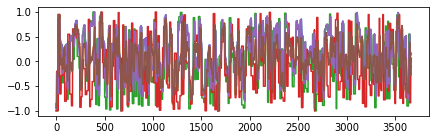

In [12]:
plt.figure(figsize=[7,2])
plt.plot(Ys)
plt.plot(Xs)

In [13]:
# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window

dump(model_params, open('model_param_MIMO.pkl', 'wb'))


In [14]:
nstep = Xs.shape[0]
val_ratio = 0.5
cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set
print(cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

1833


/tmp/ipykernel_667652/2699983935.py:3: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [15]:
X_train = []
Y_train = []
for i in range(window,len(Xs_train)):
    X_train.append(Xs_train[i-window:i,:])
    Y_train.append(Ys_train[i])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)):
    X_val.append(Xs_val[i-window:i,:])
    Y_val.append(Ys_val[i])

In [16]:
# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [17]:
# Demension of training data set
np.shape(X_train), np.shape(Y_train)

((1828, 5, 4), (1828, 2))

In [18]:
# # Initialize LSTM model
model_lstm = Sequential()

model_lstm.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=Y_train.shape[1])) #units = number of outputs
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

2022-05-24 03:54:44.277066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-24 03:54:44.277096: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-24 03:54:44.277113: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (megatron): /proc/driver/nvidia/version does not exist
2022-05-24 03:54:44.277297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Fit (and time) LSTM model
t0 = time.time()
result_lstm = model_lstm.fit(X_train, Y_train, epochs = 300, batch_size = 250,\
                             callbacks=[es_lstm],\
                             verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))


Epoch 98: early stopping
Runtime: 40.63 s


In [20]:
#%% Save LSTM model file
model_lstm.save('MPC_MIMO_TCLab_onestep_LSTM_110000.h5')

## 2. Transformer

In [21]:
n_feature = X_train.shape[2]
n_label = Y_train.shape[1]

encoder_input = tf.keras.layers.Input(shape=(window, n_feature))
xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(encoder_input,encoder_input)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(xl,xl)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)


xl = tf.keras.layers.Flatten()(xl)
yl = tf.keras.layers.Dense(n_label, activation='linear')(xl)
model_trans = tf.keras.Model(inputs=encoder_input, outputs=yl, name="mhl")
model_trans.compile(optimizer='Adam',loss='MSE',metrics='accuracy')

# Allow for early exit
es_trans = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

t0 = time.time()
result_trans = model_trans.fit(X_train,Y_train,epochs=300,batch_size=32, \
                               callbacks=[es_trans], \
                               verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()

print('Runtime: %.2f s' %(t1-t0))


Epoch 87: early stopping
Runtime: 39.95 s


In [22]:
#%% Save Transformer model file
model_trans.save('MPC_MIMO_TCLab_onestep_Trans_110000.h5')

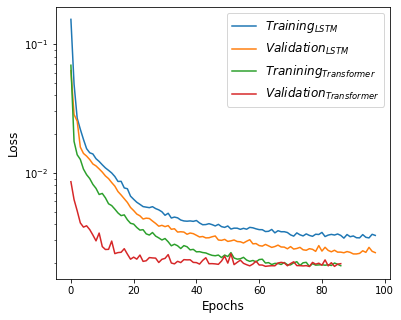

In [23]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(result_lstm.history['loss'],label='$Training_{LSTM}$')
plt.semilogy(result_lstm.history['val_loss'],label='$Validation_{LSTM}$')
plt.semilogy(result_trans.history['loss'],label='$Tranining_{Transformer}$')
plt.semilogy(result_trans.history['val_loss'],label='$Validation_{Transformer}$')
plt.legend(loc=1, fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

sec = str(sec)
interval = str(interval)


# plt.savefig('Loss_surrogate_SISO_FOPDT_' + sec + '_' + interval + 's.eps', format='eps')
plt.savefig('Loss_surrogate_SISO_FOPDT_' + sec + '_' + interval + 's.png')


## 5. Using measured values to predict next step

### LSTM

In [24]:
# # Load NN Models
model_lstm = load_model('MPC_MIMO_TCLab_onestep_LSTM_110000.h5')
model_trans = load_model('MPC_MIMO_TCLab_onestep_Trans_110000.h5')

58/58 [==============================] - 0s 5ms/step


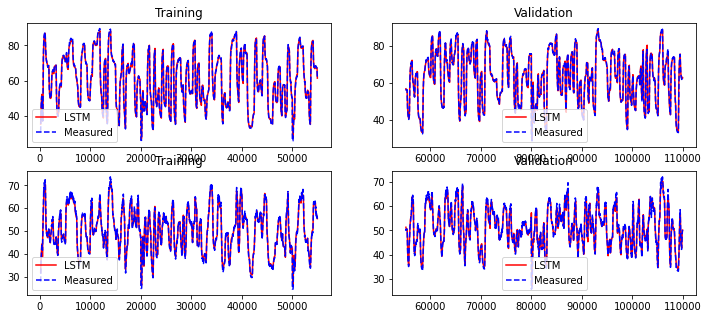

In [25]:
# Verify the fit of the model
Yp_train_lstm = model_lstm.predict(X_train)
Yp_val_lstm = model_lstm.predict(X_val)

# un-scale outputs
Yu_train_lstm = s2.inverse_transform(Yp_train_lstm) # model prediction
Ym_train = s2.inverse_transform(Y_train) # measured value

Yu_val_lstm = s2.inverse_transform(Yp_val_lstm) # model prediction
Ym_val = s2.inverse_transform(Y_val) # measured value

plt.figure(0, figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(data.index[window:cut_index],Yu_train_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(data.index[cut_index+window:],Yu_val_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()

plt.subplot(2,2,3)
plt.plot(data.index[window:cut_index],Yu_train_lstm[:,1],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,1],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,4)
plt.plot(data.index[cut_index+window:],Yu_val_lstm[:,1],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,1],'b--',label='Measured')
plt.title('Validation')
plt.legend()



# plt.savefig('1.LSTM_Measured_SISO_FOPDT_' + sec + '_' + interval + 's.eps', format='eps')
# plt.savefig('1.LSTM_Measured_SISO_FOPDT_' + sec + '_' + interval + 's.png')


### Transformer

58/58 [==============================] - 0s 3ms/step


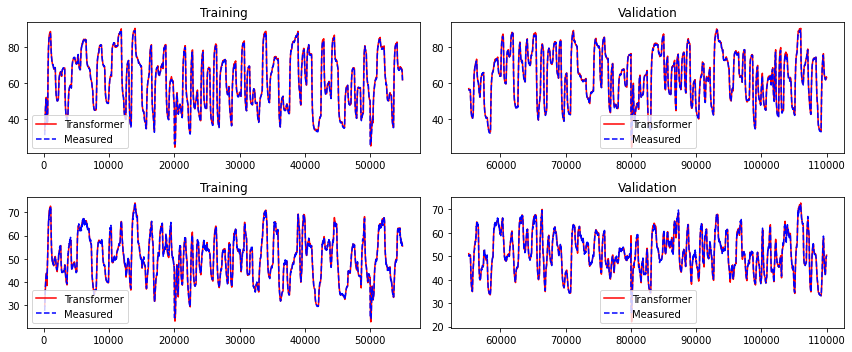

In [26]:
# Verify the fit of the model
Yp_train_trans = model_trans.predict(X_train)
Yp_val_trans = model_trans.predict(X_val)

# un-scale outputs
Yu_train_trans = s2.inverse_transform(Yp_train_trans) # model prediction
Ym_train = s2.inverse_transform(Y_train) # measured value

Yu_val_trans = s2.inverse_transform(Yp_val_trans) # model prediction
Ym_val = s2.inverse_transform(Y_val) # measured value

plt.figure(0, figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(data.index[window:cut_index],Yu_train_trans[:,0],'r-',label='Transformer')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(data.index[cut_index+window:],Yu_val_trans[:,0],'r-',label='Transformer')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.subplot(2,2,3)
plt.plot(data.index[window:cut_index],Yu_train_trans[:,1],'r-',label='Transformer')
plt.plot(data.index[window:cut_index],Ym_train[:,1],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,4)
plt.plot(data.index[cut_index+window:],Yu_val_trans[:,1],'r-',label='Transformer')
plt.plot(data.index[cut_index+window:],Ym_val[:,1],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.tight_layout()



# plt.savefig('1.Transformer_Measured_SISO_FOPDT_' + sec + '_' + interval + 's.eps', format='eps')
# plt.savefig('1.Transformer_Measured_SISO_FOPDT_' + sec + '_' + interval + 's.png')



## 6. Using predicted values to predict next step

### LSTM

In [27]:
Xsq = Xs.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model_lstm.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_train_lstm = Ytu[window:cut_index]
Ytu_val_lstm = Ytu[cut_index+window:]

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


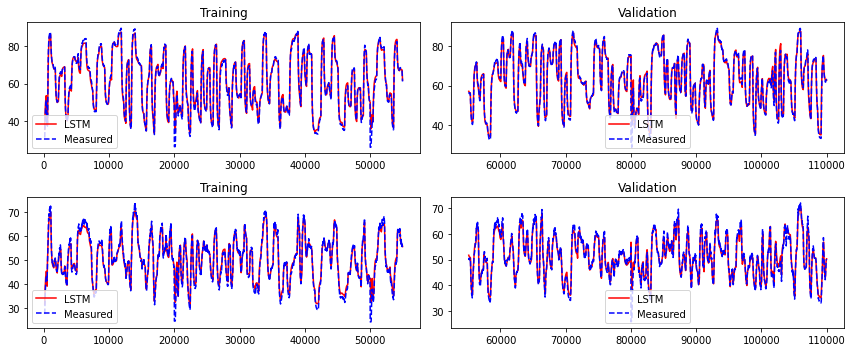

In [28]:
plt.figure(0, figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(data.index[window:cut_index],Ytu_train_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(data.index[cut_index+window:],Ytu_val_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.subplot(2,2,3)
plt.plot(data.index[window:cut_index],Ytu_train_lstm[:,1],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,1],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,4)
plt.plot(data.index[cut_index+window:],Ytu_val_lstm[:,1],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,1],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.tight_layout()



# plt.savefig('2.LSTM_Values_SISO_FOPDT_' + sec + '_' + interval + 's.eps', format='eps')
# plt.savefig('2.LSTM_Values_SISO_FOPDT_' + sec + '_' + interval + 's.png')



In [29]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(y=Ytu_val_lstm[:,0],name="T1"), row=1, col=1)
fig.add_trace(go.Scatter(y=Ym_val[:,0],name="T1_meas"), row=1, col=1)
fig.add_trace(go.Scatter(y=Ytu_val_lstm[:,1],name="T2"), row=2, col=1)
fig.add_trace(go.Scatter(y=Ym_val[:,1],name="T2_meas"), row=2, col=1)

### Transformer


In [30]:
Xsq = Xs.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model_trans.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_train_trans = Ytu[window:cut_index]
Ytu_val_trans = Ytu[cut_index+window:]

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


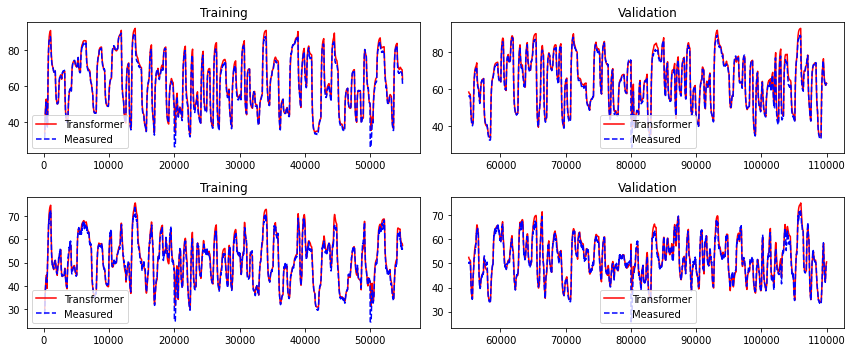

In [31]:
plt.figure(0, figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(data.index[window:cut_index],Ytu_train_trans[:,0],'r-',label='Transformer')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(data.index[cut_index+window:],Ytu_val_trans[:,0],'r-',label='Transformer')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.subplot(2,2,3)
plt.plot(data.index[window:cut_index],Ytu_train_trans[:,1],'r-',label='Transformer')
plt.plot(data.index[window:cut_index],Ym_train[:,1],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,4)
plt.plot(data.index[cut_index+window:],Ytu_val_trans[:,1],'r-',label='Transformer')
plt.plot(data.index[cut_index+window:],Ym_val[:,1],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.tight_layout()



# plt.savefig('2.Transformer_Values_SISO_FOPDT_' + sec + '_' + interval + 's.eps', format='eps')
# plt.savefig('2.Transformer_Values_SISO_FOPDT_' + sec + '_' + interval + 's.png')



In [32]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(y=Ytu_val_trans[:,0],name="T1"), row=1, col=1)
fig.add_trace(go.Scatter(y=Ym_val[:,0],name="T1_meas"), row=1, col=1)
fig.add_trace(go.Scatter(y=Ytu_val_trans[:,1],name="T2"), row=2, col=1)
fig.add_trace(go.Scatter(y=Ym_val[:,1],name="T2_meas"), row=2, col=1)

# Model Validation Results for paper

In [33]:
# Load NN model parameters and MinMaxScaler
model_params = load(open(path + 'model_param_MIMO.pkl', 'rb'))
s1 = model_params['Xscale']
s2 = model_params['yscale']
window = model_params['window']

# Load validation data
tcLab = pd.read_pickle('TCLab_MIMO_Data_003_25000.pkl')

# Downsample
interval = 30

downsampled_interval = interval # New interval (sec)
tcLab_resample = tcLab.iloc[::downsampled_interval, :]

# Select a Data Range to show
tcLab_resample = tcLab_resample[500:800]


# Scale
Xs = s1.transform(tcLab_resample[['H1', 'H2', 'T1', 'T2']].to_numpy())
Ys = s2.transform(tcLab_resample[['T1', 'T2']].to_numpy())

FileNotFoundError: [Errno 2] No such file or directory: 'TCLab_MIMO_Data_003_25000.pkl'

In [ ]:
# Make snapshots
X_val = []
Y_val = []
for i in range(window,len(Xs)):
    X_val.append(Xs[i-window:i,:])
    Y_val.append(Ys[i])

In [ ]:
# Reshape data to format accepted by LSTM
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [ ]:
#Load NN Models
model_lstm = load_model('MPC_MIMO_TCLab_onestep_LSTM_110000.h5')
model_trans = load_model('MPC_MIMO_TCLab_onestep_Trans_110000.h5')

### LSTM-Onestep model evaluation

In [ ]:
Xsq = Xs.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model_lstm.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_val_lstm = Ytu

Ym_val = s2.inverse_transform(Y_val)

### Transformer-Onestep model evaluation

In [ ]:
Xsq = Xs.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model_trans.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_val_trans = Ytu

In [ ]:
Ysq.shape

### Plotting

In [ ]:
plt.figure(0, figsize=(6,4))
plt.subplot(2,1,1)
plt.plot(tcLab_resample.index,Ytu_val_lstm[:,0],'r-',label='LSTM')
plt.plot(tcLab_resample.index[window:],Ym_val[:,0],'b--',label='Measured')
plt.title('LSTM-Onestep model Validation',fontsize=15)
plt.ylabel("T1", fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.subplot(2,1,2)
plt.plot(tcLab_resample.index,Ytu_val_lstm[:,1],'r-',label='LSTM')
plt.plot(tcLab_resample.index[window:],Ym_val[:,1],'b--',label='Measured')
# plt.title('Validation')
plt.ylabel("T2",fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.tight_layout()


plt.savefig('TCLab_validation_LSTM_Onestep_data1.eps', format='eps')
plt.savefig('TCLab_validation_LSTM_Onestep_data1.png')

plt.figure(1, figsize=(6,4))
plt.subplot(2,1,1)
plt.plot(tcLab_resample.index,Ytu_val_trans[:,0],'r-',label='Transformer')
plt.plot(tcLab_resample.index[window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Transformer-Onestep model Validation',fontsize=15)
plt.ylabel("T1",fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.subplot(2,1,2)
plt.plot(tcLab_resample.index,Ytu_val_trans[:,1],'r-',label='Transformer')
plt.plot(tcLab_resample.index[window:],Ym_val[:,1],'b--',label='Measured')
# plt.title('Validation')
plt.ylabel("T2",fontsize=13)
plt.xlabel("Time (sec)",fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.tight_layout()


plt.savefig('TCLab_validation_Transformer_Onestep_data1.eps', format='eps')
plt.savefig('TCLab_validation_Transformer_Onestep_data1.png')